In [1]:
# 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, log_loss, precision_score, recall_score, f1_score
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [2]:
import pandas as pd

# 1) CSV 불러오기 & match_id 생성
df = pd.read_csv('Matches.csv', parse_dates=['MatchDate'])
df = df.reset_index().rename(columns={'index':'match_id'})

# 2) 홈/원정 각각 long 포맷으로 전환
home = df[['match_id','MatchDate','HomeTeam','FTHome','FTAway']].copy()
home = home.assign(
    team           = home['HomeTeam'],
    goals_for      = home['FTHome'],
    goals_against  = home['FTAway'],
    venue          = 'Home'
)[['match_id','MatchDate','team','goals_for','goals_against','venue']]

away = df[['match_id','MatchDate','AwayTeam','FTAway','FTHome']].copy()
away = away.assign(
    team           = away['AwayTeam'],
    goals_for      = away['FTAway'],
    goals_against  = away['FTHome'],
    venue          = 'Away'
)[['match_id','MatchDate','team','goals_for','goals_against','venue']]

matches_long = pd.concat([home, away], ignore_index=True)

# 3) 정렬하고 인덱스 재설정 (꼭 필요)
matches_long = matches_long.sort_values(['team','MatchDate']).reset_index(drop=True)

# 4) 과거 3·5경기 득실 합계 계산 (transform 이용)
for N in (3, 5):
    # 먼저 “현재 경기” 제외를 위해 shift()
    shifted_gf = matches_long.groupby('team')['goals_for']     .shift()
    shifted_ga = matches_long.groupby('team')['goals_against'] .shift()

    # rolling 합계 계산
    matches_long[f'GF{N}'] = (shifted_gf
                              .groupby(matches_long['team'])
                              .transform(lambda x: x.rolling(N).sum()))
    matches_long[f'GA{N}'] = (shifted_ga
                              .groupby(matches_long['team'])
                              .transform(lambda x: x.rolling(N).sum()))

# 5) 홈/Away별로 다시 뽑아서 이름 바꾸기
home_stats = (
    matches_long[matches_long['venue']=='Home']
    .set_index('match_id')[['GF3','GA3','GF5','GA5']]
    .rename(columns={
        'GF3':'GF3Home','GA3':'GA3Home',
        'GF5':'GF5Home','GA5':'GA5Home'
    })
)
away_stats = (
    matches_long[matches_long['venue']=='Away']
    .set_index('match_id')[['GF3','GA3','GF5','GA5']]
    .rename(columns={
        'GF3':'GF3Away','GA3':'GA3Away',
        'GF5':'GF5Away','GA5':'GA5Away'
    })
)

# 6) map으로 원본 df에 컬럼 추가
for col in home_stats.columns:
    df[col] = df['match_id'].map(home_stats[col])
for col in away_stats.columns:
    df[col] = df['match_id'].map(away_stats[col])

# 7) 불필요해진 match_id 제거 (선택)
df = df.drop(columns=['match_id'])

# 8) 결과 확인
print(df[[
    'MatchDate','HomeTeam','AwayTeam',
    'GF3Home','GA3Home','GF3Away','GA3Away',
    'GF5Home','GA5Home','GF5Away','GA5Away'
]].tail())

C:\Users\naidj\AppData\Local\Temp\ipykernel_29292\2874721640.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Matches.csv', parse_dates=['MatchDate'])


        MatchDate   HomeTeam  AwayTeam  GF3Home  GA3Home  GF3Away  GA3Away  \
230552 2025-06-01  Cartagena  Mirandes      5.0      6.0      5.0      3.0   
230553 2025-06-01    Almeria  Tenerife      3.0      2.0      0.0      2.0   
230554 2025-06-01  La Coruna     Elche      3.0      6.0      4.0      5.0   
230555 2025-06-01     Oviedo     Cadiz      3.0      1.0      6.0      2.0   
230556 2025-06-01    Cordoba  Albacete      4.0      9.0      5.0      3.0   

        GF5Home  GA5Home  GF5Away  GA5Away  
230552      7.0      9.0      8.0      4.0  
230553     10.0      3.0      2.0      4.0  
230554      9.0      9.0      6.0      6.0  
230555      6.0      2.0      9.0      6.0  
230556      9.0     12.0      9.0      9.0  


In [3]:
df.columns

Index(['Division', 'MatchDate', 'MatchTime', 'HomeTeam', 'AwayTeam', 'HomeElo',
       'AwayElo', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'FTHome',
       'FTAway', 'FTResult', 'HTHome', 'HTAway', 'HTResult', 'HomeShots',
       'AwayShots', 'HomeTarget', 'AwayTarget', 'HomeFouls', 'AwayFouls',
       'HomeCorners', 'AwayCorners', 'HomeYellow', 'AwayYellow', 'HomeRed',
       'AwayRed', 'OddHome', 'OddDraw', 'OddAway', 'MaxHome', 'MaxDraw',
       'MaxAway', 'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 'HandiSize',
       'HandiHome', 'HandiAway', 'C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB',
       'C_PHB', 'GF3Home', 'GA3Home', 'GF5Home', 'GA5Home', 'GF3Away',
       'GA3Away', 'GF5Away', 'GA5Away'],
      dtype='object')

In [4]:
cols = ['Division', 'MatchDate', 'HomeTeam', 'AwayTeam', 'HomeElo',
       'AwayElo', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'FTResult', 'GF3Home', 'GA3Home', 'GF5Home', 'GA5Home', 'GF3Away',
       'GA3Away', 'GF5Away', 'GA5Away']

df_1 = df[cols].copy()

In [5]:
df_1

,Division,MatchDate,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,Form5Away,FTResult,GF3Home,GA3Home,GF5Home,GA5Home,GF3Away,GA3Away,GF5Away,GA5Away
0,F1,2000-07-28,Marseille,Troyes,1686.34,1586.57,0.0,0.0,0.0,0.0,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F1,2000-07-28,Paris SG,Strasbourg,1714.89,1642.51,0.0,0.0,0.0,0.0,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F2,2000-07-28,Wasquehal,Nancy,1465.08,1633.80,0.0,0.0,0.0,0.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F1,2000-07-29,Auxerre,Sedan,1635.58,1624.22,0.0,0.0,0.0,0.0,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F1,2000-07-29,Bordeaux,Metz,1734.34,1673.11,0.0,0.0,0.0,0.0,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230552,SP2,2025-06-01,Cartagena,Mirandes,1339.21,1544.15,3.0,6.0,7.0,13.0,A,5.0,6.0,7.0,9.0,5.0,3.0,8.0,4.0
230553,SP2,2025-06-01,Almeria,Tenerife,1544.16,1433.67,4.0,10.0,1.0,3.0,H,3.0,2.0,10.0,3.0,0.0,2.0,2.0,4.0
230554,SP2,2025-06-01,La Coruna,Elche,1473.67,1569.98,0.0,3.0,3.0,7.0,A,3.0,6.0,9.0,9.0,4.0,5.0,6.0,6.0
230555,SP2,2025-06-01,Oviedo,Cadiz,1574.90,1525.76,7.0,13.0,6.0,9.0,H,3.0,1.0,6.0,2.0,6.0,2.0,9.0,6.0


In [6]:
from merge_understat_xg import merge_understat_xg_multi

df_update = merge_understat_xg_multi(
    csv_path='df_1.csv',
    save_path="club_matches_with_xg.csv",
    seasons=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021, 2022, 2023,2024],
    leagues=["ENG-Premier League", "ESP-La Liga", "ITA-Serie A",
        "GER-Bundesliga", "FRA-Ligue 1"]
)

[07/03/25 18:12:15] INFO     No custom team name replacements found. You can configure these in       ]8;id=307686;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=461931;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_config.py#91\91]8;;\
                             C:\Users\naidj\soccerdata\config\teamname_replacements.json.                          

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=253241;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=362351;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_config.py#197\197]8;;\
                             C:\Users\naidj\soccerdata\config\league_dict.json.                                    

                    INFO     Saving cached data to C:\Users\naidj\soccerdata\data\Understat          ]8;id=569429;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=1762;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py:145:  ]8;id=317056;file://C:\Users\naidj\AppData\Local\Programs\Python\Python39\lib\warnings.py\warnings.py]8;;\:]8;id=237015;file://C:\Users\naidj\AppData\Local\Programs\Python\Python39\lib\warnings.py#109\109]8;;\
                             UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"                   
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[07/03/25 18:12:16] INFO     Saving cached data to C:\Users\naidj\soccerdata\data\Understat          ]8;id=887398;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=679216;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py:145:  ]8;id=303650;file://C:\Users\naidj\AppData\Local\Programs\Python\Python39\lib\warnings.py\warnings.py]8;;\:]8;id=264747;file://C:\Users\naidj\AppData\Local\Programs\Python\Python39\lib\warnings.py#109\109]8;;\
                             UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"                   
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

                    INFO     Saving cached data to C:\Users\naidj\soccerdata\data\Understat          ]8;id=849459;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=926609;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py:145:  ]8;id=163302;file://C:\Users\naidj\AppData\Local\Programs\Python\Python39\lib\warnings.py\warnings.py]8;;\:]8;id=419542;file://C:\Users\naidj\AppData\Local\Programs\Python\Python39\lib\warnings.py#109\109]8;;\
                             UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"                   
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

                    INFO     Saving cached data to C:\Users\naidj\soccerdata\data\Understat          ]8;id=700160;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=14583;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py:145:  ]8;id=105882;file://C:\Users\naidj\AppData\Local\Programs\Python\Python39\lib\warnings.py\warnings.py]8;;\:]8;id=206641;file://C:\Users\naidj\AppData\Local\Programs\Python\Python39\lib\warnings.py#109\109]8;;\
                             UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"                   
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

                    INFO     Saving cached data to C:\Users\naidj\soccerdata\data\Understat          ]8;id=805090;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=613134;file://e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py#263\263]8;;\

                    WARNING  e:\rookies_module1\.venv\lib\site-packages\soccerdata\_common.py:145:  ]8;id=826059;file://C:\Users\naidj\AppData\Local\Programs\Python\Python39\lib\warnings.py\warnings.py]8;;\:]8;id=964070;file://C:\Users\naidj\AppData\Local\Programs\Python\Python39\lib\warnings.py#109\109]8;;\
                             UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"                   
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

✅ 저장 완료: club_matches_with_xg.csv (행 수: 230557)


In [7]:
df_update

,Division,MatchDate,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,Form5Away,...,GF5Away,GA5Away,h_xg,a_xg,league,xG_diff,xg_margin,xg_ratio,rolling_xg_home_5,rolling_xg_away_5
0,F1,2000-07-28,Marseille,Troyes,1686.34,1586.57,0.0,0.0,0.0,0.0,...,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,NaN
1,F1,2000-07-28,Paris SG,Strasbourg,1714.89,1642.51,0.0,0.0,0.0,0.0,...,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,NaN
2,F2,2000-07-28,Wasquehal,Nancy,1465.08,1633.80,0.0,0.0,0.0,0.0,...,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,NaN
18,F2,2000-07-29,Niort,Angers,1469.16,1422.21,0.0,0.0,0.0,0.0,...,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,NaN
17,F2,2000-07-29,Nimes,Sochaux,1449.91,1575.12,0.0,0.0,0.0,0.0,...,NaN,NaN,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230550,SP2,2025-06-01,Santander,Granada,1527.51,1537.00,2.0,5.0,6.0,7.0,...,6.0,7.0,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,NaN
230549,SP2,2025-06-01,Levante,Eibar,1605.75,1529.63,9.0,10.0,9.0,10.0,...,8.0,3.0,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,NaN
230547,T1,2025-06-01,Bodrumspor,Besiktas,1345.44,1494.38,3.0,3.0,4.0,10.0,...,12.0,5.0,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,NaN
230551,SP2,2025-06-01,Huesca,Eldense,1496.86,1423.86,3.0,4.0,5.0,6.0,...,6.0,10.0,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,NaN,NaN


In [8]:
df_cleand = df_update.dropna()

In [9]:
df_cleand.to_csv('data_cleand_big5.csv', index=False)

In [10]:
df_cleand.columns

Index(['Division', 'MatchDate', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo',
       'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'FTResult',
       'GF3Home', 'GA3Home', 'GF5Home', 'GA5Home', 'GF3Away', 'GA3Away',
       'GF5Away', 'GA5Away', 'h_xg', 'a_xg', 'league', 'xG_diff', 'xg_margin',
       'xg_ratio', 'rolling_xg_home_5', 'rolling_xg_away_5'],
      dtype='object')

In [11]:
df_cleand

,Division,MatchDate,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,Form5Away,...,GF5Away,GA5Away,h_xg,a_xg,league,xG_diff,xg_margin,xg_ratio,rolling_xg_home_5,rolling_xg_away_5
101869,F1,2014-08-09,Nantes,Lens,1562.52,1495.52,2.0,6.0,6.0,8.0,...,9.0,3.0,1.025,0.167128,FRA-Ligue 1,0.857872,0.857872,6.132987,1.025000,0.167128
101868,F1,2014-08-09,Montpellier,Bordeaux,1578.93,1614.53,0.0,4.0,5.0,8.0,...,9.0,5.0,1.01756,0.750184,FRA-Ligue 1,0.267376,0.267376,1.356412,1.017560,0.750184
101867,F1,2014-08-09,Lille,Metz,1725.01,1522.30,4.0,8.0,7.0,11.0,...,8.0,1.0,1.54468,0.057137,FRA-Ligue 1,1.487543,1.487543,27.034151,1.544680,0.057137
101865,F1,2014-08-09,Evian Thonon Gaillard,Caen,1574.11,1528.42,6.0,6.0,2.0,8.0,...,11.0,7.0,0.813737,1.23869,FRA-Ligue 1,-0.424953,0.424953,0.656933,0.813737,1.238690
101870,F1,2014-08-09,Nice,Toulouse,1550.23,1583.32,0.0,3.0,4.0,5.0,...,5.0,6.0,2.21481,1.56361,FRA-Ligue 1,0.6512,0.6512,1.416471,2.214810,1.563610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230504,E0,2025-05-25,Liverpool,Crystal Palace,2008.67,1820.28,1.0,7.0,7.0,9.0,...,9.0,5.0,1.92122,1.4144,ENG-Premier League,0.50682,0.50682,1.358328,1.981056,2.570123
230505,E0,2025-05-25,Manchester United,Aston Villa,1797.14,1877.14,0.0,1.0,9.0,12.0,...,9.0,3.0,2.96259,0.335222,ENG-Premier League,2.627368,2.627368,8.837669,1.931547,1.486084
230506,E0,2025-05-25,Newcastle United,Everton,1882.33,1776.20,4.0,7.0,7.0,7.0,...,7.0,6.0,1.1591,1.07279,ENG-Premier League,0.08631,0.08631,1.080453,2.382512,1.034701
230510,E0,2025-05-25,Wolverhampton Wanderers,Brentford,1739.45,1820.23,0.0,6.0,6.0,12.0,...,13.0,8.0,1.10889,1.97196,ENG-Premier League,-0.86307,0.86307,0.562329,1.754727,1.353331


### 여기부터 실행

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, roc_auc_score, accuracy_score

from soccerdata.fbref import FBref 
from pathlib import Path

# 학습 모델들
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier

In [13]:
# 1) CSV 불러오기 & match_id 생성
data = pd.read_csv('data_cleand_big5.csv', parse_dates=['MatchDate'])
data = data.reset_index().rename(columns={'index':'match_id'})

In [14]:
data

,match_id,Division,MatchDate,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,...,GF5Away,GA5Away,h_xg,a_xg,league,xG_diff,xg_margin,xg_ratio,rolling_xg_home_5,rolling_xg_away_5
0,0,F1,2014-08-09,Nantes,Lens,1562.52,1495.52,2.0,6.0,6.0,...,9.0,3.0,1.025000,0.167128,FRA-Ligue 1,0.857872,0.857872,6.132987,1.025000,0.167128
1,1,F1,2014-08-09,Montpellier,Bordeaux,1578.93,1614.53,0.0,4.0,5.0,...,9.0,5.0,1.017560,0.750184,FRA-Ligue 1,0.267376,0.267376,1.356412,1.017560,0.750184
2,2,F1,2014-08-09,Lille,Metz,1725.01,1522.30,4.0,8.0,7.0,...,8.0,1.0,1.544680,0.057137,FRA-Ligue 1,1.487543,1.487543,27.034151,1.544680,0.057137
3,3,F1,2014-08-09,Evian Thonon Gaillard,Caen,1574.11,1528.42,6.0,6.0,2.0,...,11.0,7.0,0.813737,1.238690,FRA-Ligue 1,-0.424953,0.424953,0.656933,0.813737,1.238690
4,4,F1,2014-08-09,Nice,Toulouse,1550.23,1583.32,0.0,3.0,4.0,...,5.0,6.0,2.214810,1.563610,FRA-Ligue 1,0.651200,0.651200,1.416471,2.214810,1.563610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10618,10618,E0,2025-05-25,Liverpool,Crystal Palace,2008.67,1820.28,1.0,7.0,7.0,...,9.0,5.0,1.921220,1.414400,ENG-Premier League,0.506820,0.506820,1.358328,1.981056,2.570123
10619,10619,E0,2025-05-25,Manchester United,Aston Villa,1797.14,1877.14,0.0,1.0,9.0,...,9.0,3.0,2.962590,0.335222,ENG-Premier League,2.627368,2.627368,8.837669,1.931547,1.486084
10620,10620,E0,2025-05-25,Newcastle United,Everton,1882.33,1776.20,4.0,7.0,7.0,...,7.0,6.0,1.159100,1.072790,ENG-Premier League,0.086310,0.086310,1.080453,2.382512,1.034701
10621,10621,E0,2025-05-25,Wolverhampton Wanderers,Brentford,1739.45,1820.23,0.0,6.0,6.0,...,13.0,8.0,1.108890,1.971960,ENG-Premier League,-0.863070,0.863070,0.562329,1.754727,1.353331


In [15]:
columns = ['MatchDate', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'FTResult', 'GF3Home', 'GA3Home', 'GF5Home', 'GA5Home', 'GF3Away', 'GA3Away', 'GF5Away', 'GA5Away',
           'h_xg', 'a_xg', 'xG_diff', 'xg_margin', 'xg_ratio', 'rolling_xg_home_5', 'rolling_xg_away_5' 
]

In [16]:
data = data[columns].copy()

In [17]:
data

,MatchDate,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,Form5Away,FTResult,...,GA3Away,GF5Away,GA5Away,h_xg,a_xg,xG_diff,xg_margin,xg_ratio,rolling_xg_home_5,rolling_xg_away_5
0,2014-08-09,Nantes,Lens,1562.52,1495.52,2.0,6.0,6.0,8.0,H,...,2.0,9.0,3.0,1.025000,0.167128,0.857872,0.857872,6.132987,1.025000,0.167128
1,2014-08-09,Montpellier,Bordeaux,1578.93,1614.53,0.0,4.0,5.0,8.0,A,...,2.0,9.0,5.0,1.017560,0.750184,0.267376,0.267376,1.356412,1.017560,0.750184
2,2014-08-09,Lille,Metz,1725.01,1522.30,4.0,8.0,7.0,11.0,D,...,0.0,8.0,1.0,1.544680,0.057137,1.487543,1.487543,27.034151,1.544680,0.057137
3,2014-08-09,Evian Thonon Gaillard,Caen,1574.11,1528.42,6.0,6.0,2.0,8.0,A,...,6.0,11.0,7.0,0.813737,1.238690,-0.424953,0.424953,0.656933,0.813737,1.238690
4,2014-08-09,Nice,Toulouse,1550.23,1583.32,0.0,3.0,4.0,5.0,H,...,4.0,5.0,6.0,2.214810,1.563610,0.651200,0.651200,1.416471,2.214810,1.563610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10618,2025-05-25,Liverpool,Crystal Palace,2008.67,1820.28,1.0,7.0,7.0,9.0,D,...,3.0,9.0,5.0,1.921220,1.414400,0.506820,0.506820,1.358328,1.981056,2.570123
10619,2025-05-25,Manchester United,Aston Villa,1797.14,1877.14,0.0,1.0,9.0,12.0,H,...,0.0,9.0,3.0,2.962590,0.335222,2.627368,2.627368,8.837669,1.931547,1.486084
10620,2025-05-25,Newcastle United,Everton,1882.33,1776.20,4.0,7.0,7.0,7.0,A,...,3.0,7.0,6.0,1.159100,1.072790,0.086310,0.086310,1.080453,2.382512,1.034701
10621,2025-05-25,Wolverhampton Wanderers,Brentford,1739.45,1820.23,0.0,6.0,6.0,12.0,D,...,6.0,13.0,8.0,1.108890,1.971960,-0.863070,0.863070,0.562329,1.754727,1.353331


In [18]:
# 2-4 데이터 전처리 : Standardize(표준화), OneHotEncoding(원-핫 인코딩)
log_columns = ['HomeElo', 'AwayElo'] # 로그 변환할 columns
standarize_columns = ['HomeElo', 'AwayElo', 'GF3Home', 'GA3Home', 'GF5Home', 'GA5Home', 'GF3Away', 'GA3Away', 'GF5Away', 'GA5Away']  # 표준화할 columns
encoding_columns = ['HomeTeam', 'AwayTeam']  # 원-핫 인코딩할 columns

# 분산이 큰 배당률 관련 columns와 Elo columns는 표준화 전에 log scale을 먼저 적용
data[log_columns] = np.log1p(data[log_columns])

# Pipeline에서 전처리 해줄 ColumnsTransformer 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('standardize', StandardScaler(), standarize_columns),  # 표준화
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True), encoding_columns)  # 원-핫 인코딩
    ],
    remainder='passthrough'  # 나머지 컬럼은 그대로 유지
)

In [19]:
# 팀의 전력 차이를 예측하기 위한 파생 column 생성

# home과 away의 Elo, xG, ppda, deep_completions 차이
data['elo_diff'] = data['HomeElo'] - data['AwayElo'] 

In [20]:
data.columns

Index(['MatchDate', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo', 'Form3Home',
       'Form5Home', 'Form3Away', 'Form5Away', 'FTResult', 'GF3Home', 'GA3Home',
       'GF5Home', 'GA5Home', 'GF3Away', 'GA3Away', 'GF5Away', 'GA5Away',
       'h_xg', 'a_xg', 'xG_diff', 'xg_margin', 'xg_ratio', 'rolling_xg_home_5',
       'rolling_xg_away_5', 'elo_diff'],
      dtype='object')

In [21]:
# # 1) 학습·테스트 시즌 분리
# train_mask = (data['MatchDate'] > '2016-08-13') & (data['MatchDate'] < '2025-01-01')
# test_mask  =  data['MatchDate'] >= '2025-01-01'

# data_train = data.loc[train_mask].copy()
# data_test  = data.loc[test_mask].copy()

from sklearn.model_selection import train_test_split

data['target'] = data['FTResult'].map({'H': 0, 'D': 1, 'A': 2})

# 비율 기준 분할 (예: 80% 학습, 20% 테스트)
data_train, data_test = train_test_split(
    data, 
    test_size=0.2,             # 20% 테스트셋
    stratify=data['target'],   # 클래스 비율 유지하려면 타겟도 넣기
    random_state=42
)

In [22]:
data_train.shape

(8498, 27)

In [23]:
data_test.shape

(2125, 27)

In [24]:
# 2) 무승부(Draw) 제거 → Home=0, Away=1
data_train = data_train[data_train['FTResult'] != 'D']
data_test  = data_test[data_test['FTResult']  != 'D']

target_map = {'H': 0, 'A': 1}

# 3) MatchDate 컬럼 삭제
data_train.drop(columns='MatchDate', inplace=True)
data_test.drop(columns='MatchDate', inplace=True)

# 4) feature 컬럼 자동 도출 & 분리
features = [c for c in data_train.columns if c != 'FTResult']

X_train = data_train[features]
X_test  = data_test[features]

y_train = data_train['FTResult'].map(target_map)
y_test  = data_test['FTResult'].map(target_map)


# 학습용/검증용 데이터 분리
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,                       # ← 앞서 만든 0/1 데이터
    test_size=0.20,
    stratify=y_train,
    random_state=42
)

In [25]:
rf = ExtraTreesClassifier(
        n_estimators   = 1900,        #
        max_depth      = 10,          # 이전에 10
        max_features   = 0.25,         # 이전에 0.3
        min_samples_leaf = 15,         # 이전에 10
        n_jobs         = -1,
        class_weight   = 'balanced_subsample',
        random_state   = 42
)

In [26]:
pipe_extra = Pipeline([
    ('preprocessor', preprocessor),  
    ('classifier', rf)                
]) 

In [27]:
from sklearn.calibration import CalibratedClassifierCV

cal_et = CalibratedClassifierCV(
    pipe_extra, 
    cv=5,
    method='isotonic'
)

cal_et.fit(X_train, y_train)

# 홀드-아웃 검증
proba_val = cal_et.predict_proba(X_val)[:, 1]
print("AUC  (cal):", round(roc_auc_score(y_val, proba_val), 3))
print("LogLoss(cal):", round(log_loss(y_val, proba_val), 3), '\n')

# 5-fold CV 성능 (원본 파이프라인)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc = cross_val_score(pipe_extra, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"AUC (5-fold) : {auc.mean():.3f} ± {auc.std():.3f}")

AUC  (cal): 1.0
LogLoss(cal): 0.0 

AUC (5-fold) : 1.000 ± 0.000


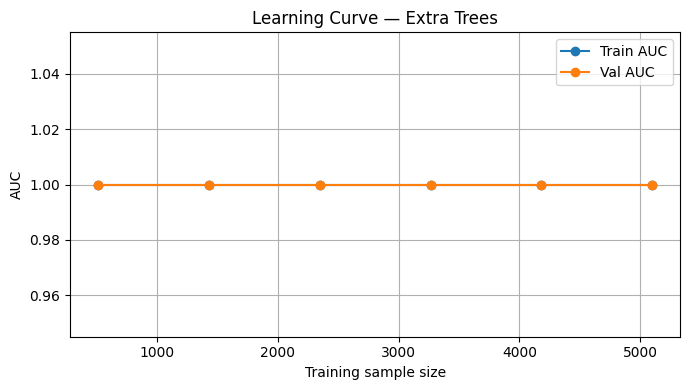

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
import pandas as pd

# NOTE: The variables `pipe` (your ExtraTrees pipeline),
#        `X_train`, `y_train` should already be defined in your notebook.
# If the code below raises NameError, run the cell where `pipe`, `X_train`, `y_train` are created.

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1) Learning curve for AUC
train_sizes, train_scores, val_scores = learning_curve(
    pipe_extra, X_train, y_train,
    cv=cv, scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 6),   # 10%, …, 100%
    n_jobs=-1, shuffle=True, random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.figure(figsize=(7,4))
plt.plot(train_sizes, train_mean, marker='o', label='Train AUC')
plt.plot(train_sizes, val_mean,   marker='o', label='Val AUC')
plt.xlabel("Training sample size")
plt.ylabel("AUC")
plt.title("Learning Curve — Extra Trees")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

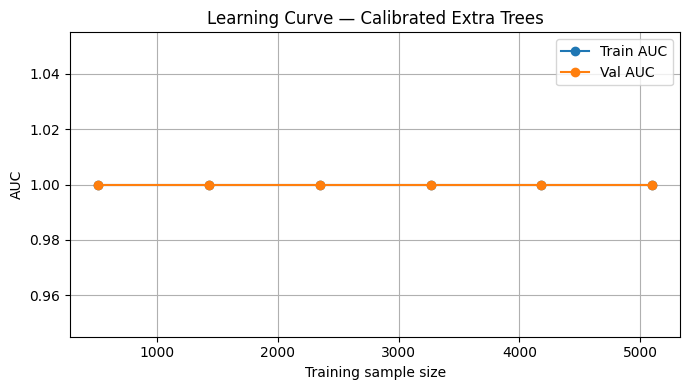

     Metric  Train mean  Val mean       Gap
0       AUC    1.000000  1.000000  0.000000
1   LogLoss    0.000027  0.000066 -0.000039
2  Accuracy    1.000000  1.000000  0.000000


In [29]:
from sklearn.model_selection import cross_validate

# 1) Learning curve – 사용 모델 cal_et
train_sizes, train_scores, val_scores = learning_curve(
    cal_et,
    X_train, y_train,
    cv=cv, scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1, shuffle=True, random_state=42
)

# 곡선 그리기
plt.figure(figsize=(7,4))
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train AUC')
plt.plot(train_sizes, val_scores.mean(axis=1),   marker='o', label='Val AUC')
plt.xlabel("Training sample size"); plt.ylabel("AUC")
plt.title("Learning Curve — Calibrated Extra Trees")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# 2) 5-fold Train vs Val 지표
scoring = {"auc":"roc_auc", "logloss":"neg_log_loss", "acc":"accuracy"}
cv_res = cross_validate(cal_et, X_train, y_train,
                        cv=cv, scoring=scoring,
                        return_train_score=True, n_jobs=-1)

metrics_df = pd.DataFrame({
    "Metric": ["AUC", "LogLoss", "Accuracy"],
    "Train mean": [cv_res["train_auc"].mean(),
                   -cv_res["train_logloss"].mean(),
                   cv_res["train_acc"].mean()],
    "Val mean":   [cv_res["test_auc"].mean(),
                   -cv_res["test_logloss"].mean(),
                   cv_res["test_acc"].mean()],
    "Gap":        [cv_res["train_auc"].mean() - cv_res["test_auc"].mean(),
                   (-cv_res["train_logloss"].mean()) - (-cv_res["test_logloss"].mean()),
                   cv_res["train_acc"].mean() - cv_res["test_acc"].mean()]
})
print(metrics_df)

In [30]:
cal_et_final = CalibratedClassifierCV(
    estimator=pipe_extra,
    method='isotonic',
    cv=cv
).fit(X_train, y_train)

# 2) 테스트셋 예측
proba_test = cal_et_final.predict_proba(X_test)[:, 1]
pred_test  = (proba_test > 0.50).astype(int)   # 임계값 0.5

# 3) 지표 출력
print("=== Final Test Metrics (2025 시즌) ===")
print(f"AUC       : {roc_auc_score(y_test, proba_test):.3f}")
print(f"Log-loss  : {log_loss(y_test, proba_test):.3f}")
print(f"Accuracy  : {accuracy_score(y_test, pred_test):.3f}\n")

print("Confusion Matrix:\n", confusion_matrix(y_test, pred_test), "\n")
print("Classification Report:\n",
      classification_report(y_test, pred_test, digits=3))

=== Final Test Metrics (2025 시즌) ===
AUC       : 1.000
Log-loss  : 0.000
Accuracy  : 1.000

Confusion Matrix:
 [[936   0]
 [  0 658]] 

Classification Report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000       936
           1      1.000     1.000     1.000       658

    accuracy                          1.000      1594
   macro avg      1.000     1.000     1.000      1594
weighted avg      1.000     1.000     1.000      1594

